# Diving into the Stack Enchange website

Stack Exchange is a big website with questions which one can upvote and answer. There are lots of different categories from software engineering, to data science to philosophy. There is something for everyone. 

In this inquiry we are going to take a closer look at the data science part of the website. There are lots of unaswered questions there and the community is quite alive. 

The first thing that can be noticed is that there are two kinds of questions. General questions, about new techniques and algorithms, and specific questions for example to understand a function in pandas. The specific rules for the site are: No distractions! Which means there are only questions and answers. No spam, no advertisement, just getting to the core of the matter fast.

For example on the home website of the data science page, there is not much else but questions. The other pages within the page include: Questions, Tags, Users and Unanswered. All content is very related to the core. Although it is interesting to explore the tags, in order te see which topics are the most popular. Especially the tags category will be a good way to answer our main question.

**What do people want to learn mostly?**

### Structure of a post. 
There are several things one post has. 

- Upvotes/Downvotes
- User
- Title
- Body
- Reactions
    - User
    - Upvotes/Downvotes
    - Time posted
- Time posted
- Viewed

In order to answer our question best we are looking at the SEDE DSSE. [This][https://data.stackexchange.com/datascience/query/new] is the online database which covers the Stack Exchange website per part. 
Anonymous users are free to download whichever dataset to get their hands on!

Most of the interesting components are to be found in the first database, `Posts`. But the table `Tags` is interesting as well because it immediately shows the popularity of the tags. Unfortunately there is no time indicator within the tags table.

In [1]:
# importing and reading in the files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

mydata2019 = pd.read_csv("2019_quest.csv")
dqdata2019 = pd.read_csv("2019_questions.csv")

In [2]:
mydata2019["Tags"].value_counts()

<machine-learning>                                                              108
<python><pandas>                                                                 56
<python>                                                                         47
<r>                                                                              38
<reinforcement-learning>                                                         32
                                                                               ... 
<machine-learning><python><neural-network><deep-learning><transfer-learning>      1
<python><jupyter><fastai>                                                         1
<machine-learning><keras><cnn><one-hot-encoding>                                  1
<python><r><matplotlib><ggplot2>                                                  1
<keras><tensorflow><rnn><training><gan>                                           1
Name: Tags, Length: 6000, dtype: int64

In [3]:
dqdata2019["Tags"].value_counts()

<machine-learning>                                                              118
<python><pandas>                                                                 58
<python>                                                                         55
<r>                                                                              38
<tensorflow>                                                                     36
                                                                               ... 
<deep-learning><rnn><backpropagation>                                             1
<nlp><dimensionality-reduction>                                                   1
<neural-network><feature-selection><feature-extraction><feature-engineering>      1
<machine-learning><linear-regression><visualization>                              1
<keras><tensorflow><rnn><training><gan>                                           1
Name: Tags, Length: 6462, dtype: int64

## Which dataset to choose?

As you are able to see my dataset has a few rows less, but the idea is pretty much the same. It is a bit suspicious that the amount of rows is 6000, as if the website has put a limit on it. Therefore I will select the original dataquest data.

In [4]:
# Renaming the dataset to Stack Exchange Data Science.
SEDS_2019 = dqdata2019 

# Exploration
In order to explore the data will firstly take a look at missing values and how to handle them.

In [5]:
SEDS_2019.isnull().sum()

Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    7432
dtype: int64

### Missing values
We can see that the only column with missing values is the FavouriteCount column. Let's see if there is any value for zero, and maybe we can fill the missing values with 0.

In [6]:
SEDS_2019["FavoriteCount"].value_counts(dropna=False)

NaN     7432
1.0      953
2.0      205
0.0      175
3.0       43
4.0       12
5.0        8
6.0        4
7.0        4
11.0       1
8.0        1
16.0       1
Name: FavoriteCount, dtype: int64

In [7]:
# I will fill NaN with 0, probably because there are far too little 0.0 values present. 
SEDS_2019["FavoriteCount"]=SEDS_2019["FavoriteCount"].fillna(0)

In [8]:
SEDS_2019.dtypes

Id                 int64
CreationDate      object
Score              int64
ViewCount          int64
Tags              object
AnswerCount        int64
FavoriteCount    float64
dtype: object

In [9]:
#Inspecting the shape of the dates.
SEDS_2019["CreationDate"].head()

0    2019-01-23 09:21:13
1    2019-01-23 09:34:01
2    2019-01-23 09:58:41
3    2019-01-23 10:57:09
4    2019-01-23 11:02:15
Name: CreationDate, dtype: object

In [10]:
# We need to convert FavoriteCount to int and CreationDate to datetime.
SEDS_2019["FavoriteCount"] = SEDS_2019["FavoriteCount"].astype(int)
SEDS_2019["CreationDate"] = pd.to_datetime(SEDS_2019["CreationDate"] , yearfirst=True)

In [11]:
SEDS_2019.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int32
dtype: object

### The Tags problem
When scrolling above one might find that there are entries for Tags with multiple values. Of course in the field Tags one can enter more tags at once. And all those tags are useful for our inquire, hence we are not going to drop any of them. But we will turn them into lists, so they become easier to access.

In [12]:
#Cleaning the original verslons of the tags column into a series of lists. 
SEDS_2019["Tags"] = SEDS_2019["Tags"].str.replace("^<|>$", "").str.split("><")
SEDS_2019.sample(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
4930,62322,2019-10-28 17:18:31,0,43,"[python, nlp, nltk, spacy]",1,0
928,56797,2019-08-01 21:03:35,0,19,[lstm],0,0
3532,60662,2019-09-23 21:51:14,0,255,[scikit-learn],2,0


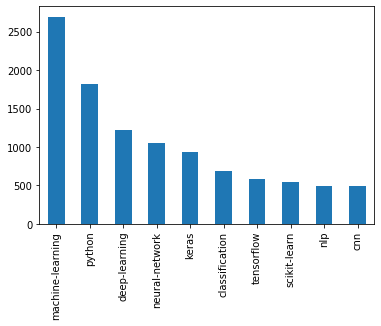

In [13]:
#We will first extract all the items in Tags in oder to do a true value count.
a = pd.Series([item for sublist in SEDS_2019['Tags'] for item in sublist])
a.value_counts().head(10).plot.bar()

In [14]:
# In order to link the views, we need the index, and now we do. 
# An alternative solution to solve the Tags problem:

tags = SEDS_2019["Tags"].explode()
tags.head()

0     machine-learning
0          data-mining
1     machine-learning
1           regression
1    linear-regression
Name: Tags, dtype: object

In [15]:
# Now let's link the views column.

tags = pd.merge(tags,SEDS_2019["ViewCount"],left_index= True,right_index=True)
tags.head()

,Tags,ViewCount
0,machine-learning,21
0,data-mining,21
1,machine-learning,25
1,regression,25
1,linear-regression,25


In [16]:
# Group by the tags, fortunately every tag can occur only once per post.
taggroup = tags.groupby("Tags")["ViewCount"].sum()
taggroup.head()

Tags
.net                     438
3d-object-detection        7
3d-reconstruction       1129
ab-test                  153
accuracy               15233
Name: ViewCount, dtype: int64

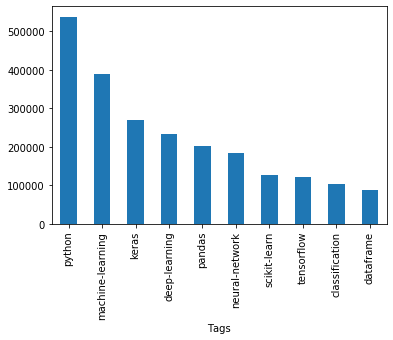

In [17]:
#Plot a sorted table of the top tags. 
taggroup.sort_values(ascending=False).head(10).plot.bar()

# Views vs. Tagcount
When we take a look at the viewcount we see that there are slight differences between how often something is only viewed versus the tag being used. Some things that stand out:

- Python is viewed more often than tagged.
- Keras moves from the no.5 spot to the no.3 spot. 
- Pandas emerges at no.5 where it was not present in tags. 

## Links between the tags
Some tags can have links, e.g. python and pandas are often used simultaneously where others are not. Let's find out a technical solution for the links between:

- Pairs of tags
- Multple tags

Let us see if there are any obvious links to be observed from the description of the tags themselves.

- Deep Learning: When we see the description for Deep Learning, it mentions it is a subdomain of `Machine Learning(ML)`. Its goal is to create `neural networks` by itself. 
- TensorFlow: This is a library designed to do `ML`, hence the link between the two.
- Keras: A `neural network` library written in `Python`. We would expect to see a link between those two.
- Pandas: the standard library for working with tables in `Python`.
- Dataframe: the standard output of `Pandas`
- Scikit-learn: This is a module built for `Python`, built upon a lof of libraries, which are not included in this top10.
- Classification: is a collection of `ML-algorithms` it classifies the different strategies an ML system could use.

## Deep Learning, a fad?

One of the questions on a lot of Data Scientists' mind is if deep learning is just a fad or not. Will it go away? What are the trends through time?

I will use a larger dataset to cover this question. It has a lot more entries in time. 

**IMPORTANT** 
The distinction between Deep Learning and Machine Learning is if human intervention is needed or not. Similar to Neural Networks, Deep Learning generates Neural Networks, but there is no human intervention. It is all AI.
Not in our top10, but also important is Reinforcement Learning, this is Deep learning where the AI does not have any data to start from but generates it through trial and error. 

Therefore I will treat Deep Learning and Reinforcement Learning as our main categories of interest.

In [18]:
# Reading in the new data
SEDS_all = pd.read_csv("all_questions.csv")
SEDS_all.dtypes

Id               int64
CreationDate    object
Tags            object
dtype: object

In [19]:
# Cleaning tags akin to above.
SEDS_all["Tags"] = SEDS_all["Tags"].str.replace("^<|>$", "").str.split("><")

# Converting creation date to yyyymm format.
SEDS_all["CreationDate"] = SEDS_all["CreationDate"].astype(str).str.replace('-','').str[0:6].astype(int)

SEDS_all.head()

,Id,CreationDate,Tags
0,45416,201902,"[python, keras, tensorflow, cnn, probability]"
1,45418,201902,[neural-network]
2,45422,201902,"[python, ibm-watson, chatbot]"
3,45426,201902,[keras]
4,45427,201902,"[r, predictive-modeling, machine-learning-mode..."


In [20]:
tagex = SEDS_all.explode('Tags')
tagex.head()

,Id,CreationDate,Tags
0,45416,201902,python
0,45416,201902,keras
0,45416,201902,tensorflow
0,45416,201902,cnn
0,45416,201902,probability


In [21]:
# I have grouped by creation date and counted the amout of tags. 
date_tags_group = tagex.groupby(['CreationDate','Tags'],as_index=False).size()
date_tags_group = date_tags_group.reset_index()
print(date_tags_group)

       CreationDate             Tags   0
0            201405             .net   1
1            201405       algorithms   2
2            201405    apache-hadoop   3
3            201405              aws   1
4            201405          bigdata  11
...             ...              ...  ..
11078        202001             word   1
11079        202001  word-embeddings   5
11080        202001         word2vec   1
11081        202001          xgboost   4
11082        202001             yolo   4

[11083 rows x 3 columns]


**Now it is time to plot some graphs!**

In [22]:
# Converting the output back to DataFrame type.
dtg = pd.DataFrame(date_tags_group)
dtg.columns = ['CreationDate', 'Tags', 'Count']
dtg.head()

,CreationDate,Tags,Count
0,201405,.net,1
1,201405,algorithms,2
2,201405,apache-hadoop,3
3,201405,aws,1
4,201405,bigdata,11


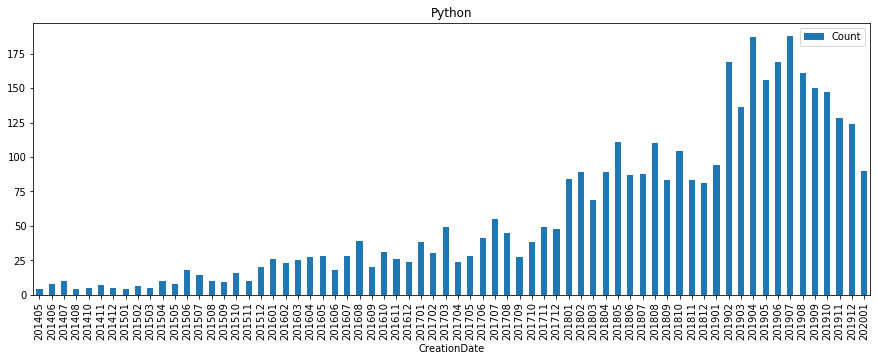

In [23]:
# selecting the tags we would like starting with python
Python = dtg[dtg['Tags'] == 'python'].reset_index()
Python = Python.drop('index',axis=1)
Python.plot.bar(x='CreationDate', y='Count', figsize=(15,5), title='Python')

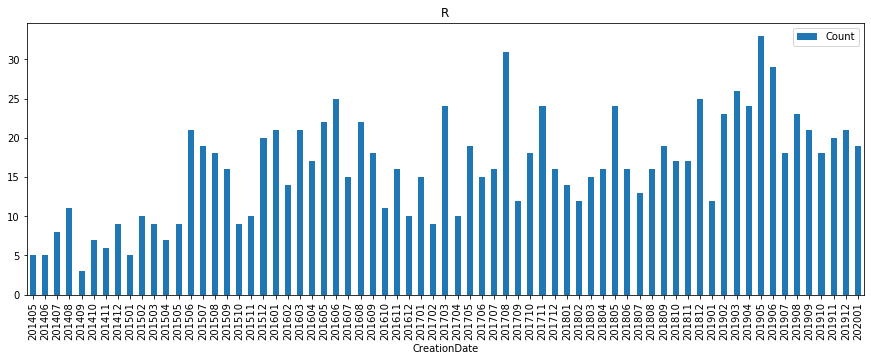

In [24]:
#let's see what R does.
R = dtg[dtg['Tags'] == 'r'].reset_index()
R = R.drop('index',axis=1)
R.plot.bar(x='CreationDate', y='Count', figsize=(15,5), title='R')

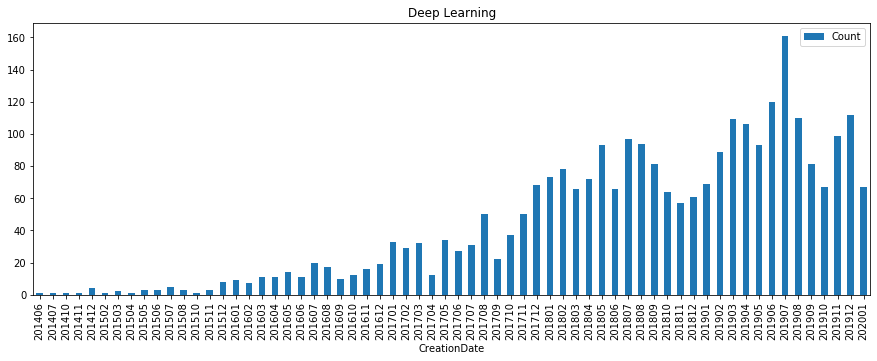

In [25]:
#And now for our juicier questions
DL = dtg[dtg['Tags'] == 'deep-learning'].reset_index()
DL = DL.drop('index',axis=1)
DL.plot.bar(x='CreationDate', y='Count', figsize=(15,5),title='Deep Learning')

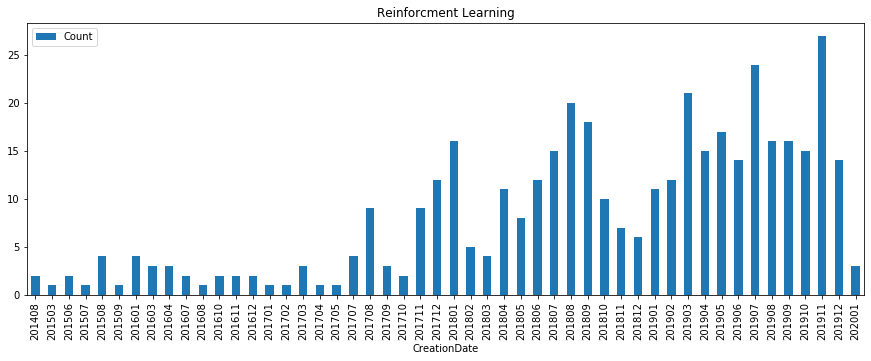

In [26]:
RL = dtg[dtg['Tags'] == 'reinforcement-learning'].reset_index()
RL = RL.drop('index',axis=1)
RL.plot.bar(x='CreationDate', y='Count', figsize=(15,5), title = 'Reinforcment Learning')

In [27]:
#One thing we might have overlooked is the percentage of DL questions compared to the total.
#Hence we group by date to see the total posts created.
dtg_no_tag = dtg.drop('Tags', axis=1)
total_counts = dtg_no_tag.groupby('CreationDate').sum().reset_index()
total_counts.columns = ['CreationDate','TotalPosts']
total_counts.head()

,CreationDate,TotalPosts
0,201405,152
1,201406,247
2,201407,183
3,201408,171
4,201409,119


In [28]:
#Now we can merge the dataframes.
DL = DL.merge(total_counts, on='CreationDate')
DL.head()

,CreationDate,Tags,Count,TotalPosts
0,201406,deep-learning,1,247
1,201407,deep-learning,1,183
2,201410,deep-learning,1,160
3,201411,deep-learning,1,156
4,201412,deep-learning,4,211


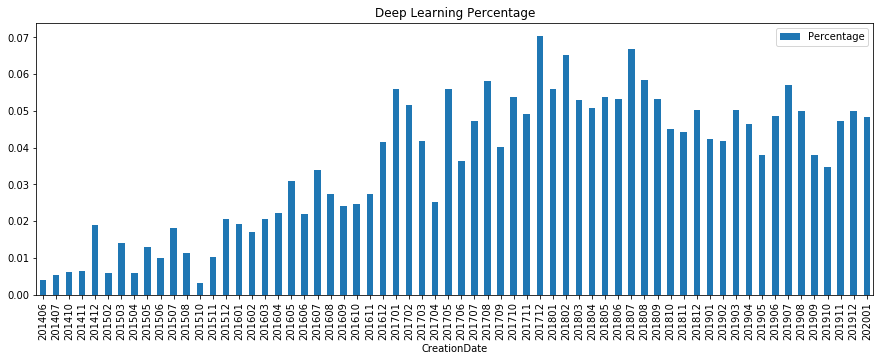

In [30]:
#Let's add the percentage now
DL["Percentage"] = DL['Count'] / DL['TotalPosts']
DL.plot.bar(x='CreationDate', y='Percentage', figsize=(15,5), title= 'Deep Learning Percentage')

In [31]:
RL = RL.merge(total_counts, on='CreationDate')

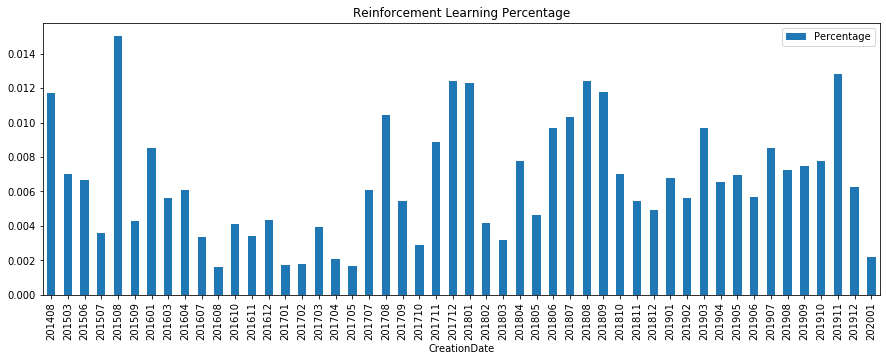

In [33]:
RL["Percentage"] = RL['Count'] / RL['TotalPosts']
RL.plot.bar(x='CreationDate', y='Percentage', figsize=(15,5), title= 'Reinforcement Learning Percentage')

In [34]:
Python = Python.merge(total_counts, on='CreationDate')

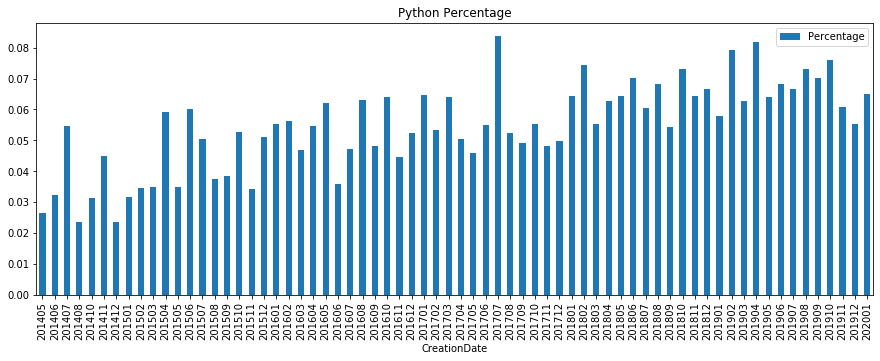

In [35]:
Python["Percentage"] = Python['Count'] / Python['TotalPosts']
Python.plot.bar(x='CreationDate', y='Percentage', figsize=(15,5), title= 'Python Percentage')

# Results counts
From counting the amount of tags through the years 

We can see that:

- Deep Learning was peaking in 2019, now it is staying roughly the same. 
- Percentage wise Deep Learning has already passed its top. 
- There is a correlation between Python and Deep Learning.
- Python has always been more popular than R. 
- Python is steadily increaing in percentage.
- Reinforcement Learning is not that popular compared to the others, however, that field seems to be slowly increasing as well. If you forget about the drop in early 2020.